In [29]:
'''
Analysis for "Technical considerations of MSK femoral cartilage segmentation using CNNs"

@author: Arjun Desai, Stanford University
         (c) Stanford University, 2018
'''

import sys
sys.path.insert(0, '../')

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
fsize = 10
params = {'legend.fontsize': fsize*0.925,          
          'axes.labelsize': fsize,
          'axes.titlesize':fsize*1.25,
          'xtick.labelsize':fsize*0.925,
          'ytick.labelsize':fsize }
sns.set(palette='pastel', rc=params)


import os
import numpy as np
import scipy.io as sio

import seaborn as sns

import utils
from analysis import analysis_funcs as af
from analysis import stats

import config
import models

import keras.backend as K
from keras.models import Model

import pandas as pd

import h5py
from mpl_toolkits.axes_grid1 import ImageGrid

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [30]:
VOLUME_2D = '/bmrNAS/people/arjun/msk_seg_networks/augment_limited/unet_2d/2018-11-07-16-05-15/'
VOLUME_2_5D_3 = '/bmrNAS/people/arjun/msk_seg_networks/volume_limited/unet_2_5d/2018-10-26-20-57-21/' # 2.5D network with 3 slices (+/-1)
VOLUME_2_5D_5 = '/bmrNAS/people/arjun/msk_seg_networks/volume_limited/unet_2_5d/2018-10-21-02-31-40/' # 2.5D network with 5 slices (+/-2)
VOLUME_2_5D_7 = '/bmrNAS/people/arjun/msk_seg_networks/volume_limited/unet_2_5d/2018-10-26-21-00-40/' # 2.5D network with 7 slices (+/-3)
VOLUME_3D = '/bmrNAS/people/arjun/msk_seg_networks/volume_limited/unet_3d_asc/' # 3D network with 4 slice inputs

def read_im(path):
    with h5py.File(path, 'r') as f:
        im = f['data'][:]
        im = im[..., np.newaxis]
        im = im[np.newaxis,...]
    return im

def im_stack(ims):
    rim = []
    for im in ims:
        rim.append(np.squeeze(im))
    
    im = np.stack(rim)
    im = np.transpose(im, (1, 2, 0))
    
    return im[np.newaxis, ...]

# image slice to analyze
im_path = '/bmrNAS/people/akshay/dl/oai_data/unet_2d/test/9968800_V00-Aug00_%03d.im'

cs = 24 #center slice

im = read_im(im_path % cs)
im_3 = im_stack([read_im(im_path % (cs+i)) for i in range(-1,2)])
im_5 = im_stack([read_im(im_path % (cs+i)) for i in range(-2,3)])
im_7 = im_stack([read_im(im_path % (cs+i)) for i in range(-3,4)])


In [31]:
# Find best weights
WEIGHTS_2D = utils.get_weights(VOLUME_2D)
WEIGHTS_2_5D_3 = utils.get_weights(VOLUME_2_5D_3)
WEIGHTS_2_5D_5 = utils.get_weights(VOLUME_2_5D_5)
WEIGHTS_2_5D_7 = utils.get_weights(VOLUME_2_5D_7)
WEIGHTS_3D = utils.get_weights(VOLUME_3D)

In [43]:
# Load weights in model
def init_model(dirpath, weights_path, config, layer_name):
    config.load_config(os.path.join(dirpath, 'config.ini'))
    model = models.get_model(config)
    model.load_weights(weights_path, by_name=True)
    
    return model

# analyze info
def get_features(dirpath, weights_path, config, layer_name, im):
    model = init_model(dirpath, weights_path, config, layer_name)

    layer = model.get_layer(layer_name)
    params = layer.get_weights()
    
    model = Model(inputs=model.inputs, outputs=[layer.output])
    features = model.predict(im)
 
    model = None
    layer = None
    K.clear_session()
    
    return features, params[0]

def mse(A, B):
    return np.mean((A - B)**2)

def measure_diff(layer):
    model_2D, _ = get_features(VOLUME_2D, WEIGHTS_2D, config.UNetConfig(create_dirs=False), layer, im)

    model_2_5D_3, _ = get_features(VOLUME_2_5D_3, WEIGHTS_2_5D_3, config.UNet2_5DConfig(create_dirs=False), layer, im_3)
    model_2_5D_5, _ = get_features(VOLUME_2_5D_5, WEIGHTS_2_5D_5, config.UNet2_5DConfig(create_dirs=False), layer, im_5)
    model_2_5D_7, _ = get_features(VOLUME_2_5D_7, WEIGHTS_2_5D_7, config.UNet2_5DConfig(create_dirs=False), layer, im_7)
    
    models = [model_2D, model_2_5D_3, model_2_5D_5, model_2_5D_7]
    labels = ['2D', '2.5D - 3', '2.5D - 5', '2.5D - 7']
    B = []
    for m in models:
        A = []
        for k in models:
            A.append(mse(m, k))
        B.append(A)
        
    return pd.DataFrame(B, index=labels, columns=labels)

def plot_weights(layer, filter_num):
    _, model_2D = get_features(VOLUME_2D, WEIGHTS_2D, config.UNetConfig(create_dirs=False), layer, im)

    _, model_2_5D_3 = get_features(VOLUME_2_5D_3, WEIGHTS_2_5D_3, config.UNet2_5DConfig(create_dirs=False), layer, im_3)
    _, model_2_5D_5 = get_features(VOLUME_2_5D_5, WEIGHTS_2_5D_5, config.UNet2_5DConfig(create_dirs=False), layer, im_5)
    _, model_2_5D_7 = get_features(VOLUME_2_5D_7, WEIGHTS_2_5D_7, config.UNet2_5DConfig(create_dirs=False), layer, im_7)
    
    models = [model_2D, model_2_5D_3, model_2_5D_5, model_2_5D_7]
    labels = ['2D', '2.5D - 3', '2.5D - 5', '2.5D - 7']
    
    fig = plt.figure(1, (15, 15))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1,3),  # creates 1 x 3 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

    for i in range(len(models)):
        weights = models[i]
        print(weights.shape)
        print(weights[..., 0] - weights[..., 1])
        print(weights[..., 1, :] - weights[..., 0, :])
        
        
#         grid[i].imshow(weights)
#         grid[i].grid(False)
#         grid[i].set_xticks([])
#         grid[i].set_yticks([])
        
#         if show_title:
#             sub_id = i + 1
#             grid[i].set_title('Subject %d' % sub_id)
    
    


config seed: None
Initializing unet with seed: None
config seed: None
Initializing 2.5d unet: input size - (288, 288, 3)
Initializing unet with seed: None
config seed: None
Initializing 2.5d unet: input size - (288, 288, 5)
Initializing unet with seed: None
config seed: None
Initializing 2.5d unet: input size - (288, 288, 7)
Initializing unet with seed: None
(3, 3, 32, 32)
[[[-0.50864434  0.25880665 -1.2166985  -0.94142866 -0.04993086
   -0.98238325 -0.95798576 -1.0011545  -0.41729075  0.5934758
   -1.0392547  -2.0643213  -2.1010356  -1.7209822  -1.5173777
   -0.85760945 -0.8379917  -1.3689723  -1.1280427  -1.6292387
    0.4866652  -0.7346815  -1.2145411  -3.092575   -2.288281
   -0.8543954   0.7487824  -0.16604662 -2.57564     0.48180306
   -1.4571002  -2.6402173 ]
  [-0.91709113 -0.6234666   0.6050812  -1.299705   -0.6290294
   -1.1206911  -1.5931994  -1.1915959  -0.852449    0.27885938
   -1.2674663  -2.3877056  -1.5858543  -1.2353668  -2.4745283
   -0.5626378  -1.0934718  -0.183916

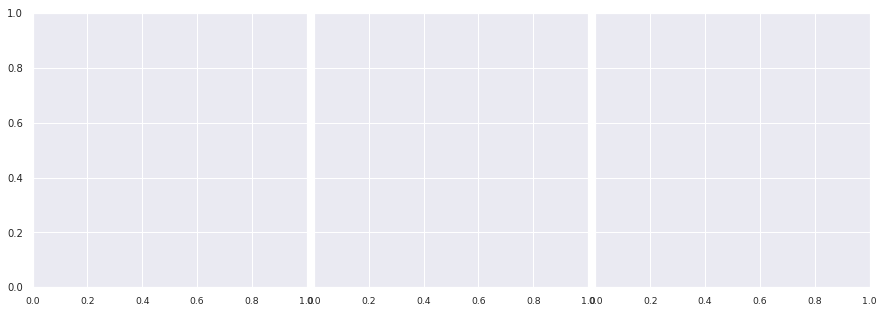

In [44]:
layer = 'conv2d_2'
# df = plot_diff(layer)
# print(df)
plot_weights(layer, 0)